<h2>Importing essential modules</h2>

In [2]:
"""Initialization for Jupyter Notebook"""
import sys 
import os 
import entity_id as eid
import pandas as pd
from msticpy.nbtools import *
import category_encoders as ce
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import IsolationForest
import xlsxwriter   
import numpy as np
from IPython.display import display
import ipywidgets
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

<h2>Notebook setup</h2">

In [3]:
nbinit.init_notebook(namespace=globals());
# Load query providers
qry_prov = QueryProvider("AzureSentinel")

Runtime dependency of PyGObject is missing.
Depends on your Linux distro, you could install it system-wide by something like:
    sudo apt install python3-gi python3-gi-cairo gir1.2-secret-1
If necessary, please refer to PyGObject's doc:
https://pygobject.readthedocs.io/en/latest/getting_started.html
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/msal_extensions/libsecret.py", line 21, in <module>
    import gi  # https://github.com/AzureAD/microsoft-authentication-extensions-for-python/wiki/Encryption-on-Linux
ModuleNotFoundError: No module named 'gi'


Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
qry_prov.connect(WorkspaceConfig())

<IPython.core.display.Javascript object>

Copy code to clipboard and authenticate here: https://microsoft.com/devicelogin


<IPython.core.display.Javascript object>

<h2>Obtaining and understanding the data</h2>

In [6]:
tables = qry_prov.schema_tables

In [7]:
print("Please select a single table you would like to analyze")
#Selecting a table from the Azure Sentinel schema through ipywidget (default is OfficeActivity)
dropdown = ipywidgets.Dropdown(
    options=sorted(tables),
    value='OfficeActivity',
    description='Tables',
)
display(dropdown)

Please select a single table you would like to analyze


Dropdown(description='Tables', index=231, options=('AACAudit', 'AACHttpRequest', 'AADDomainServicesAccountLogo…

In [8]:
#defining the table
table = dropdown.value 
#using the entity_id module to get entites for our selected table
query = eid.EntityIdentifier(qry_prov)

In [9]:
table

'OfficeActivity'

In [10]:
#Raw data before feature engineering
raw_data = qry_prov.exec_query(table)

<IPython.core.display.Javascript object>

In [11]:
raw_data.head()

,TenantId,Application,UserDomain,UserAgent,RecordType,TimeGenerated,Operation,OrganizationId,OrganizationId_,UserType,UserKey,OfficeWorkload,ResultStatus,ResultReasonType,OfficeObjectId,UserId,UserId_,ClientIP,ClientIP_,Scope,Site_,ItemType,EventSource,Source_Name,MachineDomainInfo,...,ChannelType,ChannelName,ChannelGuid,ExtraProperties,AddOnType,AddonName,TabType,Name,OldValue,NewValue,ItemName,ChatThreadId,ChatName,CommunicationType,AADGroupId,AddOnGuid,AppDistributionMode,TargetUserId,OperationScope,AzureADAppId,OperationProperties,AppId,ClientAppId,Type,_ResourceId
0,8ecf8077-cf51-4820-aadd-14040956f35d,,,,50,2021-05-31 12:11:18+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F88D275,Exchange,Succeeded,Succeeded,,seb@seccxp.ninja,seb@seccxp.ninja,,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",7ab7862c-4c57-491e-8a45-d52a7e023983,,OfficeActivity,
1,8ecf8077-cf51-4820-aadd-14040956f35d,,,,ExchangeAdmin,2021-05-31 12:35:25+00:00,Set-User,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,DcAdmin,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),Exchange,True,True,NAMPR06A007.PROD.OUTLOOK.COM/Microsoft Exchange Hosted Organizations/seccxpninja.onmicrosoft.com...,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,None,,,OfficeActivity,
2,8ecf8077-cf51-4820-aadd-14040956f35d,,,,50,2021-05-31 13:11:26+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F88D275,Exchange,Succeeded,Succeeded,,seb@seccxp.ninja,seb@seccxp.ninja,,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",7ab7862c-4c57-491e-8a45-d52a7e023983,,OfficeActivity,
3,8ecf8077-cf51-4820-aadd-14040956f35d,,,,ExchangeAdmin,2021-05-31 16:05:34+00:00,Set-User,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,DcAdmin,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),Exchange,True,True,NAMPR06A007.PROD.OUTLOOK.COM/Microsoft Exchange Hosted Organizations/seccxpninja.onmicrosoft.com...,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),,,,,,,,,...,,,,None,,,,,,,,,,,,,,,,,None,,,OfficeActivity,
4,8ecf8077-cf51-4820-aadd-14040956f35d,,,,MicrosoftTeams,2021-05-31 16:12:44+00:00,MemberAdded,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Application,62b732f7-fc71-40bc-b27d-35efcb0509de,MicrosoftTeams,,,,Microsoft Teams Sync,Microsoft Teams Sync,,,,,,,,,...,,,,[],,,,,,,SocTeam,,,Team,d05ba55c-593e-4bfa-8011-26e0626b5c14,,,,,,None,,,OfficeActivity,


In [12]:
raw_data.shape

(26159, 131)

<h2>Feature Engineering</h2>

In [13]:
def convert_to_string(df):
    """
    Converts all the columns of the given dataframe to string
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    
    Returns
    -------
    
    a new dataframe type object with all columns as strings 
    """
    df_complete_string = df.copy()
    for column in df_complete_string.columns:
        df_complete_string[column] = df_complete_string[column].astype(str)
    

In [14]:
def clean_extra_columns(df):
    """
    Cleans all extra columns of the table. Removes any identical columns with each and every datapoint being same for example URL and URL_ which have the exact same data just different column names
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    
    Returns
    -------
    
    a new dataframe type object with no redundant column
    """

    #exit if dataframe is empty
    if df.empty == True:
        print("The dataframe has no data")
        return 

    cols_list = list(df.columns)
    df_columns_copy = (cols_list).copy()
    cols_p = 0
    colscopy_p = 0
    seen = []
    to_delete = []
    while cols_p < len(cols_list):
        if df[cols_list[cols_p]].equals(df[cols_list[colscopy_p]]) and (cols_p != colscopy_p) and (cols_list[cols_p] not in seen): #if equates to True
            seen.append(cols_list[colscopy_p])
            to_delete.append(cols_list[colscopy_p])
            if colscopy_p == len(cols_list)-1:
                cols_p+=1
                colscopy_p = 0
            else:
                colscopy_p+=1
        elif colscopy_p == len(cols_list)-1:
            cols_p+=1
            colscopy_p = 0
        else:
            colscopy_p+=1
            
    df.drop(columns = to_delete, axis=1, inplace= True)
    return df           

In [15]:
clean_extra_columns(raw_data)

,TenantId,Application,UserAgent,RecordType,TimeGenerated,Operation,OrganizationId,UserType,UserKey,OfficeWorkload,ResultStatus,OfficeObjectId,UserId,ClientIP,Site_,ItemType,EventSource,Site_Url,SourceRelativeUrl,SourceFileName,SourceFileExtension,DestinationRelativeUrl,DestinationFileName,DestinationFileExtension,Event_Data,...,TargetUserOrGroupType,MessageId,Members,TeamName,TeamGuid,ChannelName,ChannelGuid,ExtraProperties,AddOnType,AddonName,TabType,Name,NewValue,ItemName,ChatThreadId,CommunicationType,AADGroupId,AddOnGuid,AppDistributionMode,OperationScope,AzureADAppId,OperationProperties,AppId,ClientAppId,Type
0,8ecf8077-cf51-4820-aadd-14040956f35d,,,50,2021-05-31 12:11:18+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F88D275,Exchange,Succeeded,,seb@seccxp.ninja,,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",7ab7862c-4c57-491e-8a45-d52a7e023983,,OfficeActivity
1,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeAdmin,2021-05-31 12:35:25+00:00,Set-User,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,DcAdmin,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),Exchange,True,NAMPR06A007.PROD.OUTLOOK.COM/Microsoft Exchange Hosted Organizations/seccxpninja.onmicrosoft.com...,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,None,,,OfficeActivity
2,8ecf8077-cf51-4820-aadd-14040956f35d,,,50,2021-05-31 13:11:26+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F88D275,Exchange,Succeeded,,seb@seccxp.ninja,,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",7ab7862c-4c57-491e-8a45-d52a7e023983,,OfficeActivity
3,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeAdmin,2021-05-31 16:05:34+00:00,Set-User,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,DcAdmin,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),Exchange,True,NAMPR06A007.PROD.OUTLOOK.COM/Microsoft Exchange Hosted Organizations/seccxpninja.onmicrosoft.com...,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,None,,,OfficeActivity
4,8ecf8077-cf51-4820-aadd-14040956f35d,,,MicrosoftTeams,2021-05-31 16:12:44+00:00,MemberAdded,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Application,62b732f7-fc71-40bc-b27d-35efcb0509de,MicrosoftTeams,,,Microsoft Teams Sync,,,,,,,,,,,,,...,,,"[{'DisplayName': 'On-Premises Directory Synchronization Service Account', 'Role': 1, 'UPN': 'Syn...",SocTeam,19:9695c2f3977a4254975475668bb52751@thread.skype,,,[],,,,,,SocTeam,,Team,d05ba55c-593e-4bfa-8011-26e0626b5c14,,,,,None,,,OfficeActivity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26154,8ecf8077-cf51-4820-aadd-14040956f35d,,,50,2021-07-31 10:45:39+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F8A6FC7,Exchange,Succeeded,,MeganB@seccxp.ninja,,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",414a677a-e50f-46ea-b89c-aebb8a9efbe2,,OfficeActivity
26155,8ecf8077-cf51-4820-aadd-14040956f35d,,,50,2021-07-31 10:45:39+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F8A6FC7,Exchange,Succeeded,,MeganB@seccxp.ninja,,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",414a677a-e50f-46ea-b89c-aebb8a9efbe2,,OfficeActivity
26156,8ecf8077-cf51-4820-aadd-14040956f35d,,,50,2021-07-31 10:45:39+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F8A6FC7,Exchange,Succeeded,,MeganB@seccxp.ninja,,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType

In [16]:
raw_data.head()

,TenantId,Application,UserAgent,RecordType,TimeGenerated,Operation,OrganizationId,UserType,UserKey,OfficeWorkload,ResultStatus,OfficeObjectId,UserId,ClientIP,Site_,ItemType,EventSource,Site_Url,SourceRelativeUrl,SourceFileName,SourceFileExtension,DestinationRelativeUrl,DestinationFileName,DestinationFileExtension,Event_Data,...,TargetUserOrGroupType,MessageId,Members,TeamName,TeamGuid,ChannelName,ChannelGuid,ExtraProperties,AddOnType,AddonName,TabType,Name,NewValue,ItemName,ChatThreadId,CommunicationType,AADGroupId,AddOnGuid,AppDistributionMode,OperationScope,AzureADAppId,OperationProperties,AppId,ClientAppId,Type
0,8ecf8077-cf51-4820-aadd-14040956f35d,,,50,2021-05-31 12:11:18+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F88D275,Exchange,Succeeded,,seb@seccxp.ninja,,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",7ab7862c-4c57-491e-8a45-d52a7e023983,,OfficeActivity
1,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeAdmin,2021-05-31 12:35:25+00:00,Set-User,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,DcAdmin,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),Exchange,True,NAMPR06A007.PROD.OUTLOOK.COM/Microsoft Exchange Hosted Organizations/seccxpninja.onmicrosoft.com...,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,None,,,OfficeActivity
2,8ecf8077-cf51-4820-aadd-14040956f35d,,,50,2021-05-31 13:11:26+00:00,MailItemsAccessed,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Regular,100320003F88D275,Exchange,Succeeded,,seb@seccxp.ninja,,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,"[{'Value': 'Bind', 'Name': 'MailAccessType'}, {'Value': 'False', 'Name': 'IsThrottled'}]",7ab7862c-4c57-491e-8a45-d52a7e023983,,OfficeActivity
3,8ecf8077-cf51-4820-aadd-14040956f35d,,,ExchangeAdmin,2021-05-31 16:05:34+00:00,Set-User,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,DcAdmin,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),Exchange,True,NAMPR06A007.PROD.OUTLOOK.COM/Microsoft Exchange Hosted Organizations/seccxpninja.onmicrosoft.com...,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),,,,,,,,,,,,,...,,,None,,,,,None,,,,,,,,,,,,,,None,,,OfficeActivity
4,8ecf8077-cf51-4820-aadd-14040956f35d,,,MicrosoftTeams,2021-05-31 16:12:44+00:00,MemberAdded,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,Application,62b732f7-fc71-40bc-b27d-35efcb0509de,MicrosoftTeams,,,Microsoft Teams Sync,,,,,,,,,,,,,...,,,"[{'DisplayName': 'On-Premises Directory Synchronization Service Account', 'Role': 1, 'UPN': 'Syn...",SocTeam,19:9695c2f3977a4254975475668bb52751@thread.skype,,,[],,,,,,SocTeam,,Team,d05ba55c-593e-4bfa-8011-26e0626b5c14,,,,,None,,,OfficeActivity


In [17]:
raw_data.shape

(26159, 79)

In [18]:
#get a dictionary of entities of the table and remove redundant columns
entities_dict = query.detect_entities(tables=[table])
for key,value in entities_dict.items():
    for tup in value:
        if tup[1] not in raw_data.columns:
            value.remove(tup)

pprint(entities_dict)

  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

{'account': [('OfficeActivity', 'UserKey'),
             ('OfficeActivity', 'UserId'),
             ('OfficeActivity', 'MailboxOwnerUPN'),
             ('OfficeActivity', 'MailboxOwnerSid'),
             ('OfficeActivity', 'LogonUserSid')],
 'host': [('OfficeActivity', 'OfficeObjectId'),
          ('OfficeActivity', 'OrganizationName'),
          ('OfficeActivity', 'ClientProcessName')],
 'ipaddress': [('OfficeActivity', 'ClientIP'),
               ('OfficeActivity', 'Client_IPAddress')]}


In [86]:
print ("What kind of entites would you like to see be analyzed?")
#Formatting data to have it in a Entity - x, Column - y format 
source_entities = list()
for key,value in entities_dict.items():
    for tup in value:
        source_entities.append("Entity - {}, Column - {}".format(key,tup[1]))

#nbwidget to select entity
#sel_entities = nbwidgets.SelectSubset(source_items=source_entities)

sel_entities = ipywidgets.Dropdown(
    options=sorted(source_entities),
    description='Entities',
)
display(sel_entities)

What kind of entites would you like to see be analyzed?


Dropdown(description='Entities', options=('Entity - account, Column - LogonUserSid', 'Entity - account, Column…

In [77]:
print ("What kind of features would you like to see be analyzed?")
#nbwidget to select features
sel_features = nbwidgets.SelectSubset(source_items=raw_data.columns)

What kind of features would you like to see be analyzed?


In [110]:
#nbwidget to select the time range
q_times = nbwidgets.QueryTime(units='day', max_before=50, before=5, max_after=50)
q_times.display()

In [23]:
def to_lower_and_replace(lst):
    """
    Makes all data in a list to lower case and replaces space with no space
    
    Parameters
    -------
    
    lst - takes in a list type object
    
    Returns
    -------
    a list type object with all elements to lower case and replaces space with no space
    """
    return [x.lower().replace(" ","") for x in lst]

In [24]:
#list of all entities 
all_entities = ["Account","Host","IP address", "URL", "Azure resource", "Registry key", "File", "File hash"]
#list of all entities selected by the user
user_entities = []
for i in sel_entities.selected_values:
    to_append = i.split("Column - ",)[1]
    user_entities.append(to_append)

all_entities = to_lower_and_replace(all_entities)
user_features = sel_features.selected_values

In [62]:
def create_subset(df, user_entities, user_features, start_date, end_date):
    """
    Creates of a subset of the raw input dataframe based on user's selected entities, features and time range
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    user_entities - list of selected user entities
    user_features- list of selected user features
    start_date - start date of the time range(inclusive)
    end_date - end date of the time range (inclusive)
    
    Returns
    -------
    
    a new dataframe type object which is a subset of the raw data based on user selected inputs
    
    """
    df_subsetted  = pd.DataFrame()
    df_subsetted = df.filter(["TimeGenerated"], axis=1)
    df_subsetted.rename(columns = {'TimeGenerated':'TimeGenerated_encoded'}, inplace = True)
    df_subsetted["TimeGenerated_encoded"] = df_subsetted["TimeGenerated_encoded"].apply(lambda x: x.timestamp())
    df_subsetted["TimeGenerated"] = df.filter(["TimeGenerated"], axis=1)

    for i in user_entities:
        df_subsetted[i] = df.filter([i])

    for i in user_features:
        df_subsetted[i] = df.filter([i])
        
    df_subsetted = df_subsetted.sort_values(by = "TimeGenerated", ascending = True)
    df_subsetted = df_subsetted.query("TimeGenerated_encoded>={} and TimeGenerated_encoded<={}".format(start_date.timestamp(), end_date.timestamp())).copy()
    df_subsetted.drop("TimeGenerated_encoded", inplace = True, axis = 1)
    df_subsetted.reset_index(inplace = True,drop = True)
    return df_subsetted


In [66]:
df_subset = create_subset(raw_data, user_entities, user_features,q_times.start, q_times.end) 

In [67]:
df_subset.head()

,TimeGenerated,UserId,Operation,OrganizationName,OriginatingServer,Parameters,RecordType,ResultStatus
0,2021-07-11 17:38:47+00:00,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),Set-User,seccxpninja.onmicrosoft.com,SN6PR06MB6445 (15.20.4308.026),"[\r\n {\r\n ""Name"": ""Identity"",\r\n ""Value"": ""4b2462a4-bbee-495a-a0e1-f23ae524cc9c\\fa796...",ExchangeAdmin,True
1,2021-07-11 17:52:07+00:00,seb@seccxpninja.onmicrosoft.com,MailItemsAccessed,seccxpninja.onmicrosoft.com,DM5PR06MB3180 (15.20.4200.000)\r\n,,50,Succeeded
2,2021-07-11 17:52:07+00:00,seb@seccxpninja.onmicrosoft.com,MailItemsAccessed,seccxpninja.onmicrosoft.com,DM5PR06MB3180 (15.20.4200.000)\r\n,,50,Succeeded
3,2021-07-11 17:57:04+00:00,john@seccxpninja.onmicrosoft.com,MailItemsAccessed,seccxpninja.onmicrosoft.com,CH2PR06MB6710 (15.20.4200.000)\r\n,,50,Succeeded
4,2021-07-11 18:25:07+00:00,MeganB@seccxp.ninja,MailItemsAccessed,seccxpninja.onmicrosoft.com,DM5PR0601MB3686 (15.20.4200.000)\r\n,,50,Succeeded


In [29]:
def nunique_nan(col):
    """
    Helper function to select count including NaN values
    
    Parameters
    -------
    
    col - column of a dataframe
    
    Returns
    -------
    
    returns count of all distinct occurences in the column
    """
    return col.nunique(dropna=False)

In [30]:
def create_aggregate_bycount(df,user_entities):
    """
    Creates a dataframe which is grouped by the user entity and has the data in the count format
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    user_entities - list of selected user entities
    
    Returns
    -------
    a new dataframe type object with data grouped by and aggregated by the user entity and the data being in the original data format 
    """
    df_aggregate = df.copy()
    df_aggregate_bycount = df_aggregate.groupby(by = user_entities, as_index = False).agg(nunique_nan) 
    return df_aggregate_bycount

In [31]:
def create_aggregate_bydata(df,user_entities):
    """
    Creates a dataframe which is grouped by the user entity and has the data in the data format
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    user_entities - list of selected user entities
    
    Returns
    -------
    a new dataframe type object with data grouped by and aggregated by the user entity and the data being in the original data format 
    """
    df_temp = df.copy()

    df_temp_bydata = df_temp.groupby(by = user_entities, as_index = False).agg(lambda x: set(x)) 
    return df_temp_bydata

In [32]:
data_aggregate = create_aggregate_bydata(df_subset, user_entities)
data_aggregate.head()

,UserId,TimeGenerated,Operation,OrganizationName,OriginatingServer,Parameters,RecordType,ResultStatus
0,AzureDevSub@seccxpninja.onmicrosoft.com,"{2021-07-20 14:19:24+00:00, 2021-07-16 17:37:55+00:00, 2021-07-25 18:35:18+00:00, 2021-07-15 16:...",{MailItemsAccessed},{seccxpninja.onmicrosoft.com},"{BN0P221MB0446 (15.20.4200.000)\r\n, CO6PR06MB7124 (15.20.4200.000)\r\n}",{},{50},{Succeeded}
1,AzurePlaygroundSub@seccxpninja.onmicrosoft.com,"{2021-07-21 09:28:55+00:00, 2021-07-25 18:04:00+00:00, 2021-07-18 15:35:36+00:00, 2021-08-05 21:...",{MailItemsAccessed},{seccxpninja.onmicrosoft.com},"{CH0P221MB0598 (15.20.4200.000)\r\n, SN6PR06MB5230 (15.20.4200.000)\r\n}",{},{50},{Succeeded}
2,CBoehmSA@seccxpninja.onmicrosoft.com,"{2021-07-15 13:05:41+00:00, 2021-07-15 13:05:52+00:00, 2021-07-16 15:13:53+00:00, 2021-07-12 13:...","{Add-RoleGroupMember, Set-SafeAttachmentPolicy, Set-SafeAttachmentRule, Set-User}",{seccxpninja.onmicrosoft.com},"{SN6PR06MB6445 (15.20.4308.027), DM5PR06MB3433 (15.20.4308.026)}","{[\r\n {\r\n ""Name"": ""Identity"",\r\n ""Value"": ""8e8a3eba-1500-4ef7-8a36-40747aec8ce9""\r\n ...",{ExchangeAdmin},{True}
3,DlpAgent,"{2021-08-11 15:45:42+00:00, 2021-08-10 06:52:10+00:00, 2021-08-10 08:05:42+00:00, 2021-08-10 07:...",{MipLabel},{},{},{},{13},{}
4,DlpPolicyEventBasedAssistantOneDriveForBusiness,"{2021-07-27 15:14:19+00:00, 2021-07-27 09:41:57+00:00, 2021-07-27 15:14:16+00:00}","{DLPRuleMatch, DLPRuleUndo}",{},{},{},{ComplianceDLPSharePoint},{}


In [33]:
count_aggregate = create_aggregate_bycount(df_subset, user_entities)
count_aggregate.head()

,UserId,TimeGenerated,Operation,OrganizationName,OriginatingServer,Parameters,RecordType,ResultStatus
0,AzureDevSub@seccxpninja.onmicrosoft.com,13,1,1,2,1,1,1
1,AzurePlaygroundSub@seccxpninja.onmicrosoft.com,44,1,1,2,1,1,1
2,CBoehmSA@seccxpninja.onmicrosoft.com,6,4,1,2,6,1,1
3,DlpAgent,8,1,1,1,1,1,1
4,DlpPolicyEventBasedAssistantOneDriveForBusiness,3,2,1,1,1,1,1


In [34]:
def column_encoder(df,user_entities):
    """
    Creates a dataframe in which the user entities are encoded to feed to the model
    
    Parameters
    -------
    
    df - takes in a dataframe type object
    user_entities - list of selected user entities
    
    Returns
    -------
    a new dataframe type object with the user entities columns encoded
    """
    encoder = ce.HashingEncoder(cols = user_entities, n_components = 32)  #this is the hash encoder object
    df_final_encoding = encoder.fit_transform(df) #fitting the dataframe
    return df_final_encoding

In [35]:
encoded_data = column_encoder(count_aggregate,user_entities)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [36]:
encoded_data.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,TimeGenerated,Operation,OrganizationName,OriginatingServer,Parameters,RecordType,ResultStatus
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,1,2,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,1,1,2,1,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,4,1,2,6,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8,1,1,1,1,1,1
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,1,1,1,1


<h2>Modeling</h2>

In [50]:
model =  IsolationForest(contamination=0.1,n_estimators=150)
model.fit(encoded_data)
prediction = model.predict(encoded_data)
encoded_data["Anomalies"] = pd.Series(prediction)
encoded_data["Anomalies"] = encoded_data["Anomalies"].map( {1: 0, -1: 1} )
scores = model.decision_function(encoded_data)

print ("Datapoints with a '1' marker are considered anomalous") 
print(encoded_data["Anomalies"].value_counts())

Datapoints with a '1' marker are considered anomalous
0    50
1     6
Name: Anomalies, dtype: int64


In [159]:
def count_anomaly(count_aggregate, encoded_data):
    """
    Creates a dataframe which only has datapoints marked off as anomalies and features in count format
    
    Parameters
    -------
    
    count_aggregate - df in which all data is aggregated by count
    encoded_data - data with user_entities encoded
    
    Returns
    -------
    a new dataframe type object with datapoints marked off as anomalies and features in count format
    """
    count_aggregate["Anomalies"] = encoded_data["Anomalies"]
    count_aggregate.rename(columns = {'TimeGenerated':'No. of Login Times'}, inplace = True)
    count_aggregate["Anomaly Score"] = round(pd.Series(scores),2)
    count_anomaly = count_aggregate[count_aggregate["Anomalies"] == 1]
    count_anomaly.reset_index(inplace = True,drop = True)
    return count_anomaly

In [160]:
def data_anomaly(data_aggregate, encoded_data):
    """
    Creates a dataframe which only has datapoints marked off as anomalies and features in raw data format
    
    Parameters
    -------
    
    count_aggregate - df in which all data is aggregated by count
    encoded_data - data with user_entities encoded
    
    Returns
    -------
    a new dataframe type object with datapoints marked off as anomalies and features in data format
    """
    data_aggregate["Anomalies"] = encoded_data["Anomalies"]
    data_aggregate.rename(columns = {'TimeGenerated':'Login Times'}, inplace = True)
    data_aggregate["Anomaly Score"] = round(pd.Series(scores),2)
    data_anomaly = data_aggregate[data_aggregate["Anomalies"] == 1]
    data_anomaly.reset_index(inplace = True,drop = True)
    return data_anomaly

In [54]:
def anomalies_to_excel(data_aggregate, data_anomaly, count_aggregate, count_anomaly):
    """
    Creates a excel file with all 4 dataframes - All data count, All data raw, Anomaly data count, Anomlay daw rata in the worksheets
    
    Parameters
    -------
    
    data_aggregate - df in which all data is aggregated by raw data
    data_anomaly - df derived from data_aggregate with only anomalies as 1
    count_aggregate - df in which all data is aggregated by count
    count_anomaly - df derived from count_aggregate with only anomalies as 1
    

    Returns
    -------
    an excel 
    """
    count = 0
    while True: 
        file_name = "DataAnomaly"
        count_num = "({})".format(count)
        extension = ".xlsx"
        if count == 0:
            exists = os.path.isfile(file_name+extension)
        else:
            exists = os.path.isfile(file_name+count_num+extension)
        if exists:
            count+=1
            continue

        else: 
            if count == 0:
                writer = pd.ExcelWriter(file_name+extension)
            else:
                writer = pd.ExcelWriter(file_name+count_num+extension)
            data_aggregate.to_excel(writer, sheet_name = "All-data-raw")
            data_anomaly.to_excel(writer, sheet_name = "Anomalous-data-raw")
            count_aggregate.to_excel(writer, sheet_name = "All-data-count")
            count_anomaly.to_excel(writer, sheet_name = "Anomalous-data-count")
            writer.save()
            break       


In [161]:
anomaly_count_model = count_anomaly(count_aggregate, encoded_data)
anomaly_data_model = data_anomaly(data_aggregate, encoded_data)

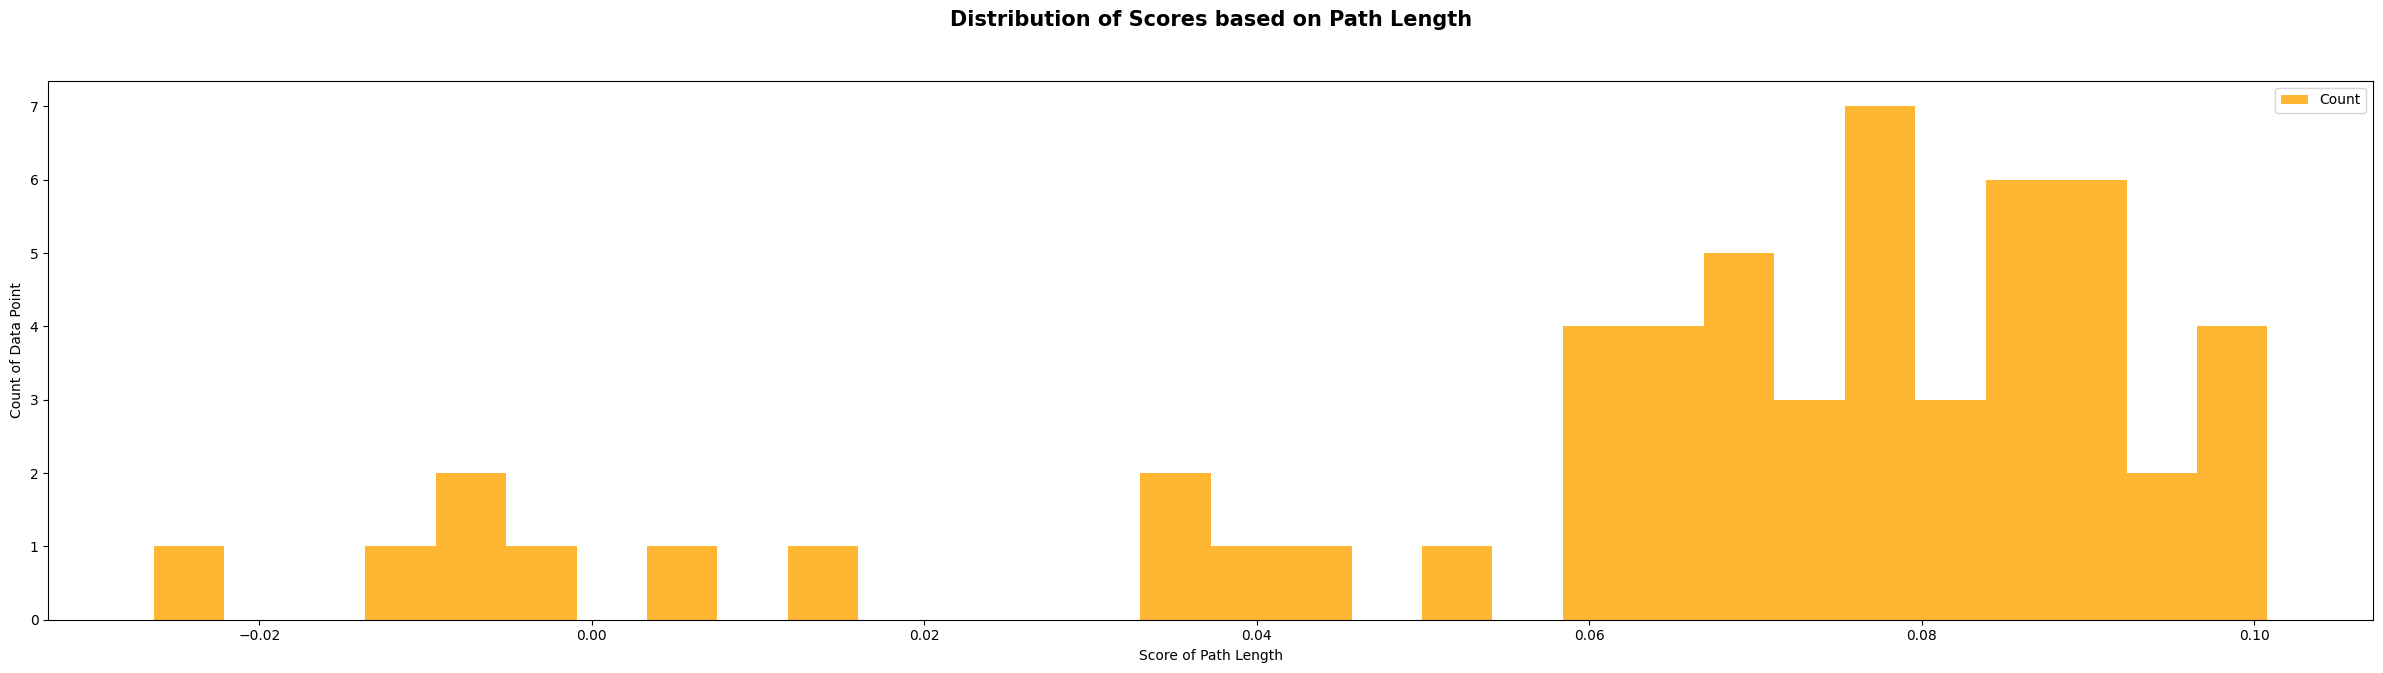

In [311]:
total_bins = 30 
fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(7)
n, bins, patches = plt.hist(scores, total_bins, color = "orange", alpha = 0.8)
plt.xlabel('Score of Path Length')
plt.ylabel('Count of Data Point')
plt.title('Distribution of Scores based on Path Length\n\n',
          fontweight ="bold",fontsize = 15)
plt.legend(["Count"])
plt.show()

In [44]:
anomalies_to_excel(data_aggregate, anomaly_data_model, count_aggregate, anomaly_count_model)

In [56]:
anomaly_count_model

,UserId,No. of Login Times,Operation,OrganizationName,OriginatingServer,Parameters,RecordType,ResultStatus,Anomalies,Anomaly Score
10,KDickens@seccxp.ninja,132,9,2,3,1,5,2,1,0.01
15,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),484,1,1,413,51,1,1,1,0.01
35,cjones@seccxp.ninja,68,14,2,4,1,7,2,1,-0.01
46,lrodriguez@seccxp.ninja,903,13,2,3,1,6,2,1,-0.01
52,sbeavers@seccxp.ninja,1352,12,2,5,1,6,2,1,-0.03
53,seb@seccxpninja.onmicrosoft.com,909,4,2,6,1,3,2,1,-0.01


In [58]:
anomaly_data_model

,UserId,Login Times,Operation,OrganizationName,OriginatingServer,Parameters,RecordType,ResultStatus,Anomalies,Anomaly Score
10,KDickens@seccxp.ninja,"{2021-08-10 07:58:14+00:00, 2021-08-10 23:42:06+00:00, 2021-07-19 15:07:29+00:00, 2021-08-10 23:...","{MessageCreatedHasLink, Send, SoftDelete, HardDelete, MailItemsAccessed, MipLabel, Update, Modif...","{seccxpninja.onmicrosoft.com, }","{, BN0P221MB0398 (15.20.4200.000)\r\n, BL3P221MB0387 (15.20.4200.000)\r\n}",{},"{50, ExchangeItemGroup, ExchangeItem, MicrosoftTeams, 43}","{, Succeeded}",1,0.01
15,NT AUTHORITY\SYSTEM (Microsoft.Exchange.Management.ForwardSync),"{2021-08-08 14:59:28+00:00, 2021-08-01 16:53:08+00:00, 2021-07-25 21:53:55+00:00, 2021-08-02 21:...",{Set-User},{seccxpninja.onmicrosoft.com},"{CH0P221MB0393 (15.20.4373.026), DM8P221MB0470 (15.20.4394.015), CY4PR06MB3350 (15.20.4308.027),...","{[\r\n {\r\n ""Name"": ""Identity"",\r\n ""Value"": ""4b2462a4-bbee-495a-a0e1-f23ae524cc9c\\ccec...",{ExchangeAdmin},{True},1,0.01
35,cjones@seccxp.ninja,"{2021-07-16 15:27:38+00:00, 2021-07-16 15:34:34+00:00, 2021-07-16 15:44:59+00:00, 2021-07-16 13:...","{Send, PageViewed, SoftDelete, MoveToDeletedItems, FolderModified, SharingInheritanceBroken, Fol...","{seccxpninja.onmicrosoft.com, }","{DM6PR06MB6170 (15.20.4200.000)\r\n, , CH0P221MB0646 (15.20.4200.000)\r\n, BL3P221MB0644 (15.20....",{},"{50, SharePointFileOperation, ExchangeItemGroup, SharePoint, ExchangeItem, 43, SharePointSharing...","{, Succeeded}",1,-0.01
46,lrodriguez@seccxp.ninja,"{2021-07-16 13:55:07+00:00, 2021-07-12 17:36:07+00:00, 2021-07-13 09:22:38+00:00, 2021-07-12 16:...","{Send, PageViewed, FileAccessedExtended, ListViewed, MoveToDeletedItems, FileDownloaded, FolderM...","{seccxpninja.onmicrosoft.com, }","{CY4PR06MB3143 (15.20.4200.000)\r\n, , BL3P221MB0420 (15.20.4200.000)\r\n}",{},"{50, 36, SharePointFileOperation, ExchangeItemGroup, SharePoint, ExchangeItem}","{, Succeeded}",1,-0.01
52,sbeavers@seccxp.ninja,"{2021-07-16 12:08:18+00:00, 2021-07-16 10:43:34+00:00, 2021-07-19 13:00:25+00:00, 2021-07-19 12:...","{SiteCollectionAdminAdded, SiteCollectionQuotaModified, Send, SoftDelete, SiteCollectionCreated,...","{seccxpninja.onmicrosoft.com, }","{, DM6PR06MB5657 (15.20.4200.000)\r\n, PH0P221MB0687 (15.20.4200.000)\r\n, BYAPR06MB5653 (15.20....",{},"{50, ExchangeItemGroup, SharePoint, ExchangeItem, 43, SharePointSharingOperation}","{, Succeeded}",1,-0.03
53,seb@seccxpninja.onmicrosoft.com,"{2021-07-29 08:09:55+00:00, 2021-08-05 17:25:26+00:00, 2021-07-15 07:35:32+00:00, 2021-08-03 02:...","{MipLabel, Send, MailItemsAccessed, Create}","{seccxpninja.onmicrosoft.com, }","{, BN6PR06MB3169 (15.20.4200.000)\r\n, DM8P221MB0375 (15.20.4200.000)\r\n, MWHPR06MB3182 (15.20....",{},"{43, 50, ExchangeItem}","{, Succeeded}",1,-0.01


<h2>Visualization</h2>

In [306]:
plt.rcdefaults()
plt.rcParams.update({'axes.facecolor':'white'})

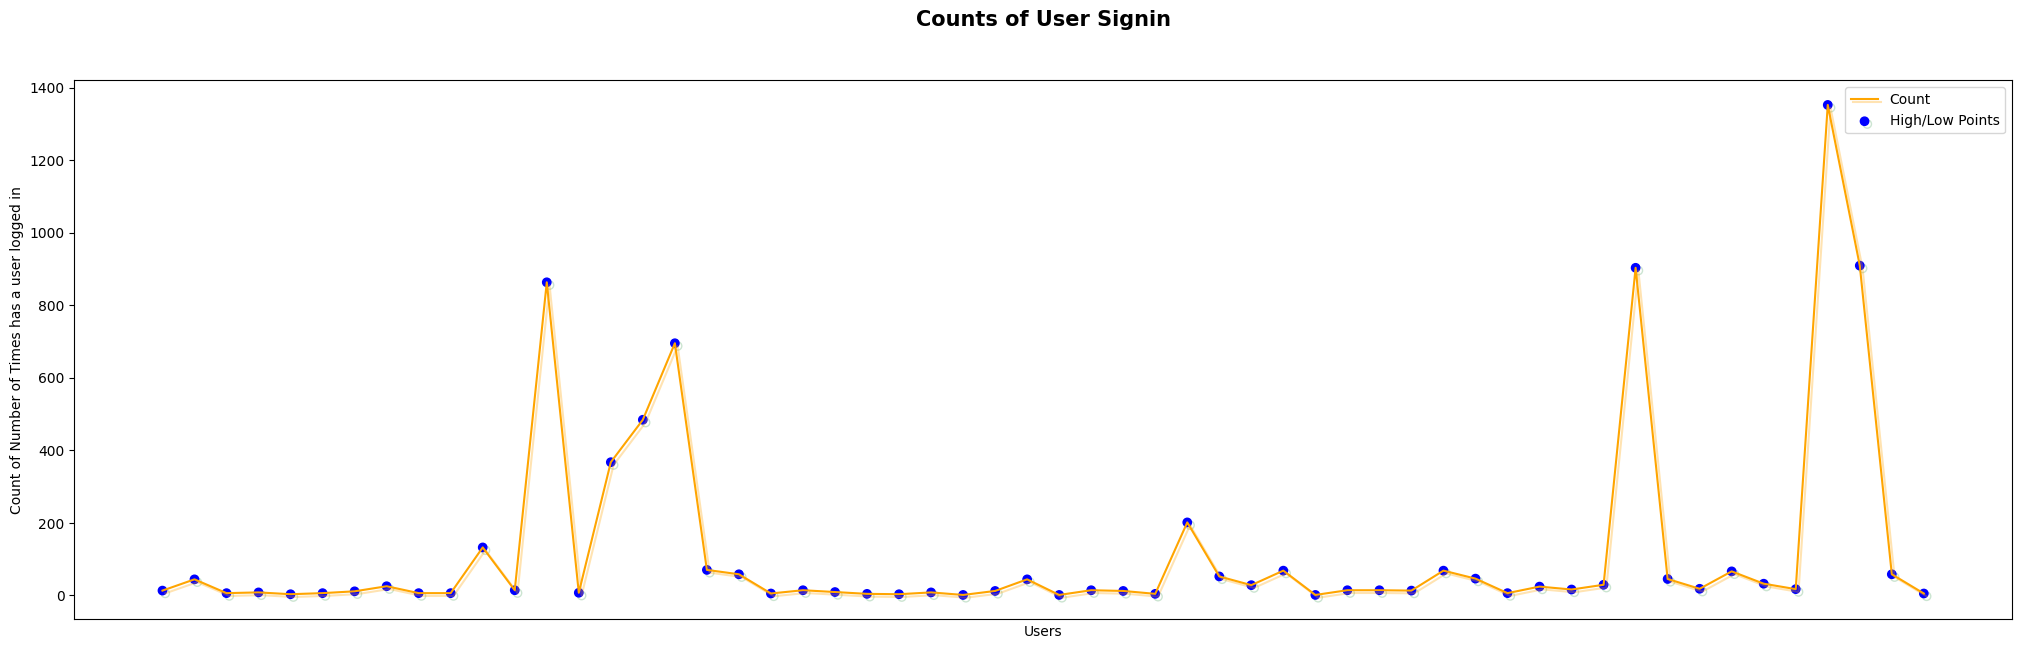

In [307]:
fig = plt.figure()
fig.set_figwidth(25)
fig.set_figheight(7)
plt.scatter(count_aggregate["UserId"], count_aggregate["No. of Login Times"], color = "blue", path_effects=[pe.SimpleLineShadow(shadow_color='g'), pe.Normal()])
plt.plot(count_aggregate["UserId"], count_aggregate["No. of Login Times"], color = "orange", path_effects=[pe.SimpleLineShadow(shadow_color='orange'), pe.Normal()])
plt.xlabel('Users')
plt.ylabel('Count of Number of Times has a user logged in')
plt.title('Counts of User Signin\n\n',
          fontweight ="bold", fontsize=15)
plt.xticks([])  
plt.rcdefaults()
# set the axes color glbally for all plots
plt.rcParams.update({'axes.facecolor':'white'})
plt.legend(["Count","High/Low Points"])
plt.show()

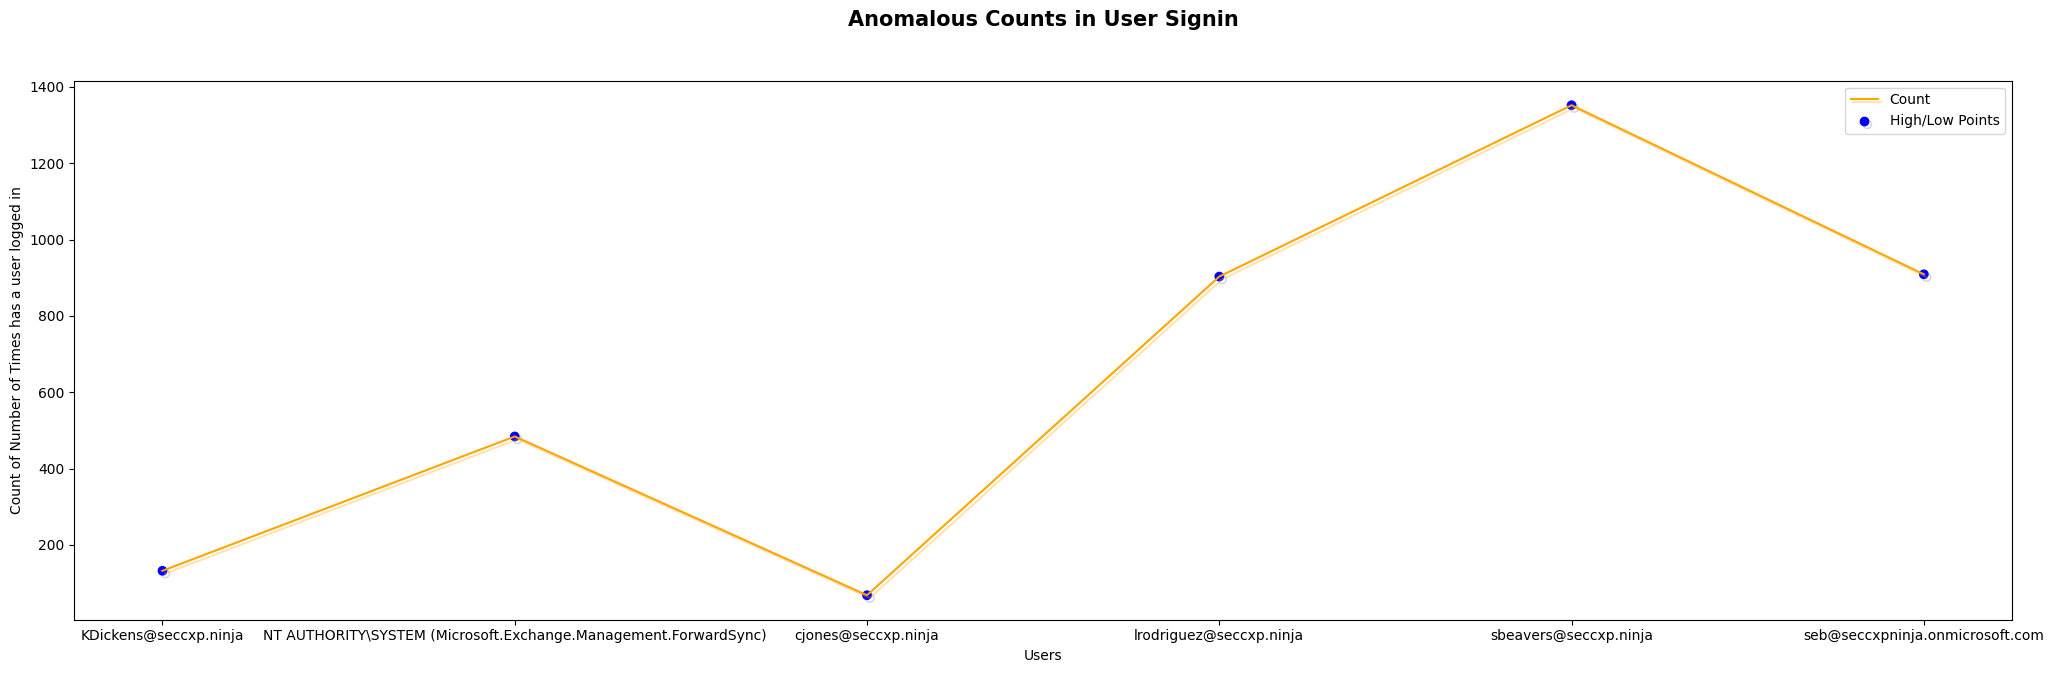

In [308]:
fig = plt.figure()
fig.set_figwidth(25)
fig.set_figheight(7)
plt.scatter(anomaly_count_model["UserId"], anomaly_count_model["No. of Login Times"], color = "blue", path_effects=[pe.SimpleLineShadow(shadow_color='b'), pe.Normal()])
plt.plot(anomaly_count_model["UserId"], anomaly_count_model["No. of Login Times"], color = "orange", path_effects=[pe.SimpleLineShadow(shadow_color='orange'), pe.Normal()])
plt.xlabel('Users')
plt.ylabel('Count of Number of Times has a user logged in')
plt.title('Anomalous Counts in User Signin\n\n',
          fontweight ="bold", fontsize=15)
plt.legend(["Count", "High/Low Points"])
plt.show()

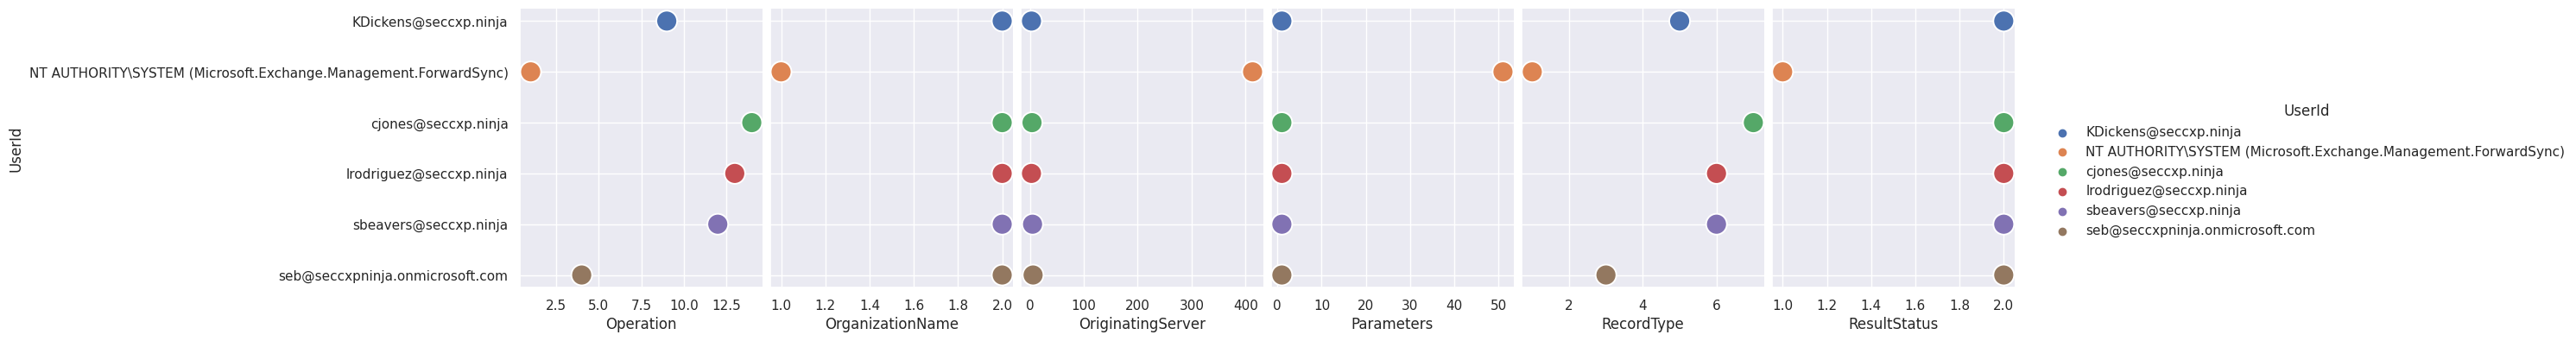

In [304]:
sns.pairplot(anomaly_count_model, x_vars = user_features , y_vars = user_entities[0], hue=user_entities[0], plot_kws={"s": 300},height = 4)
fig.show()

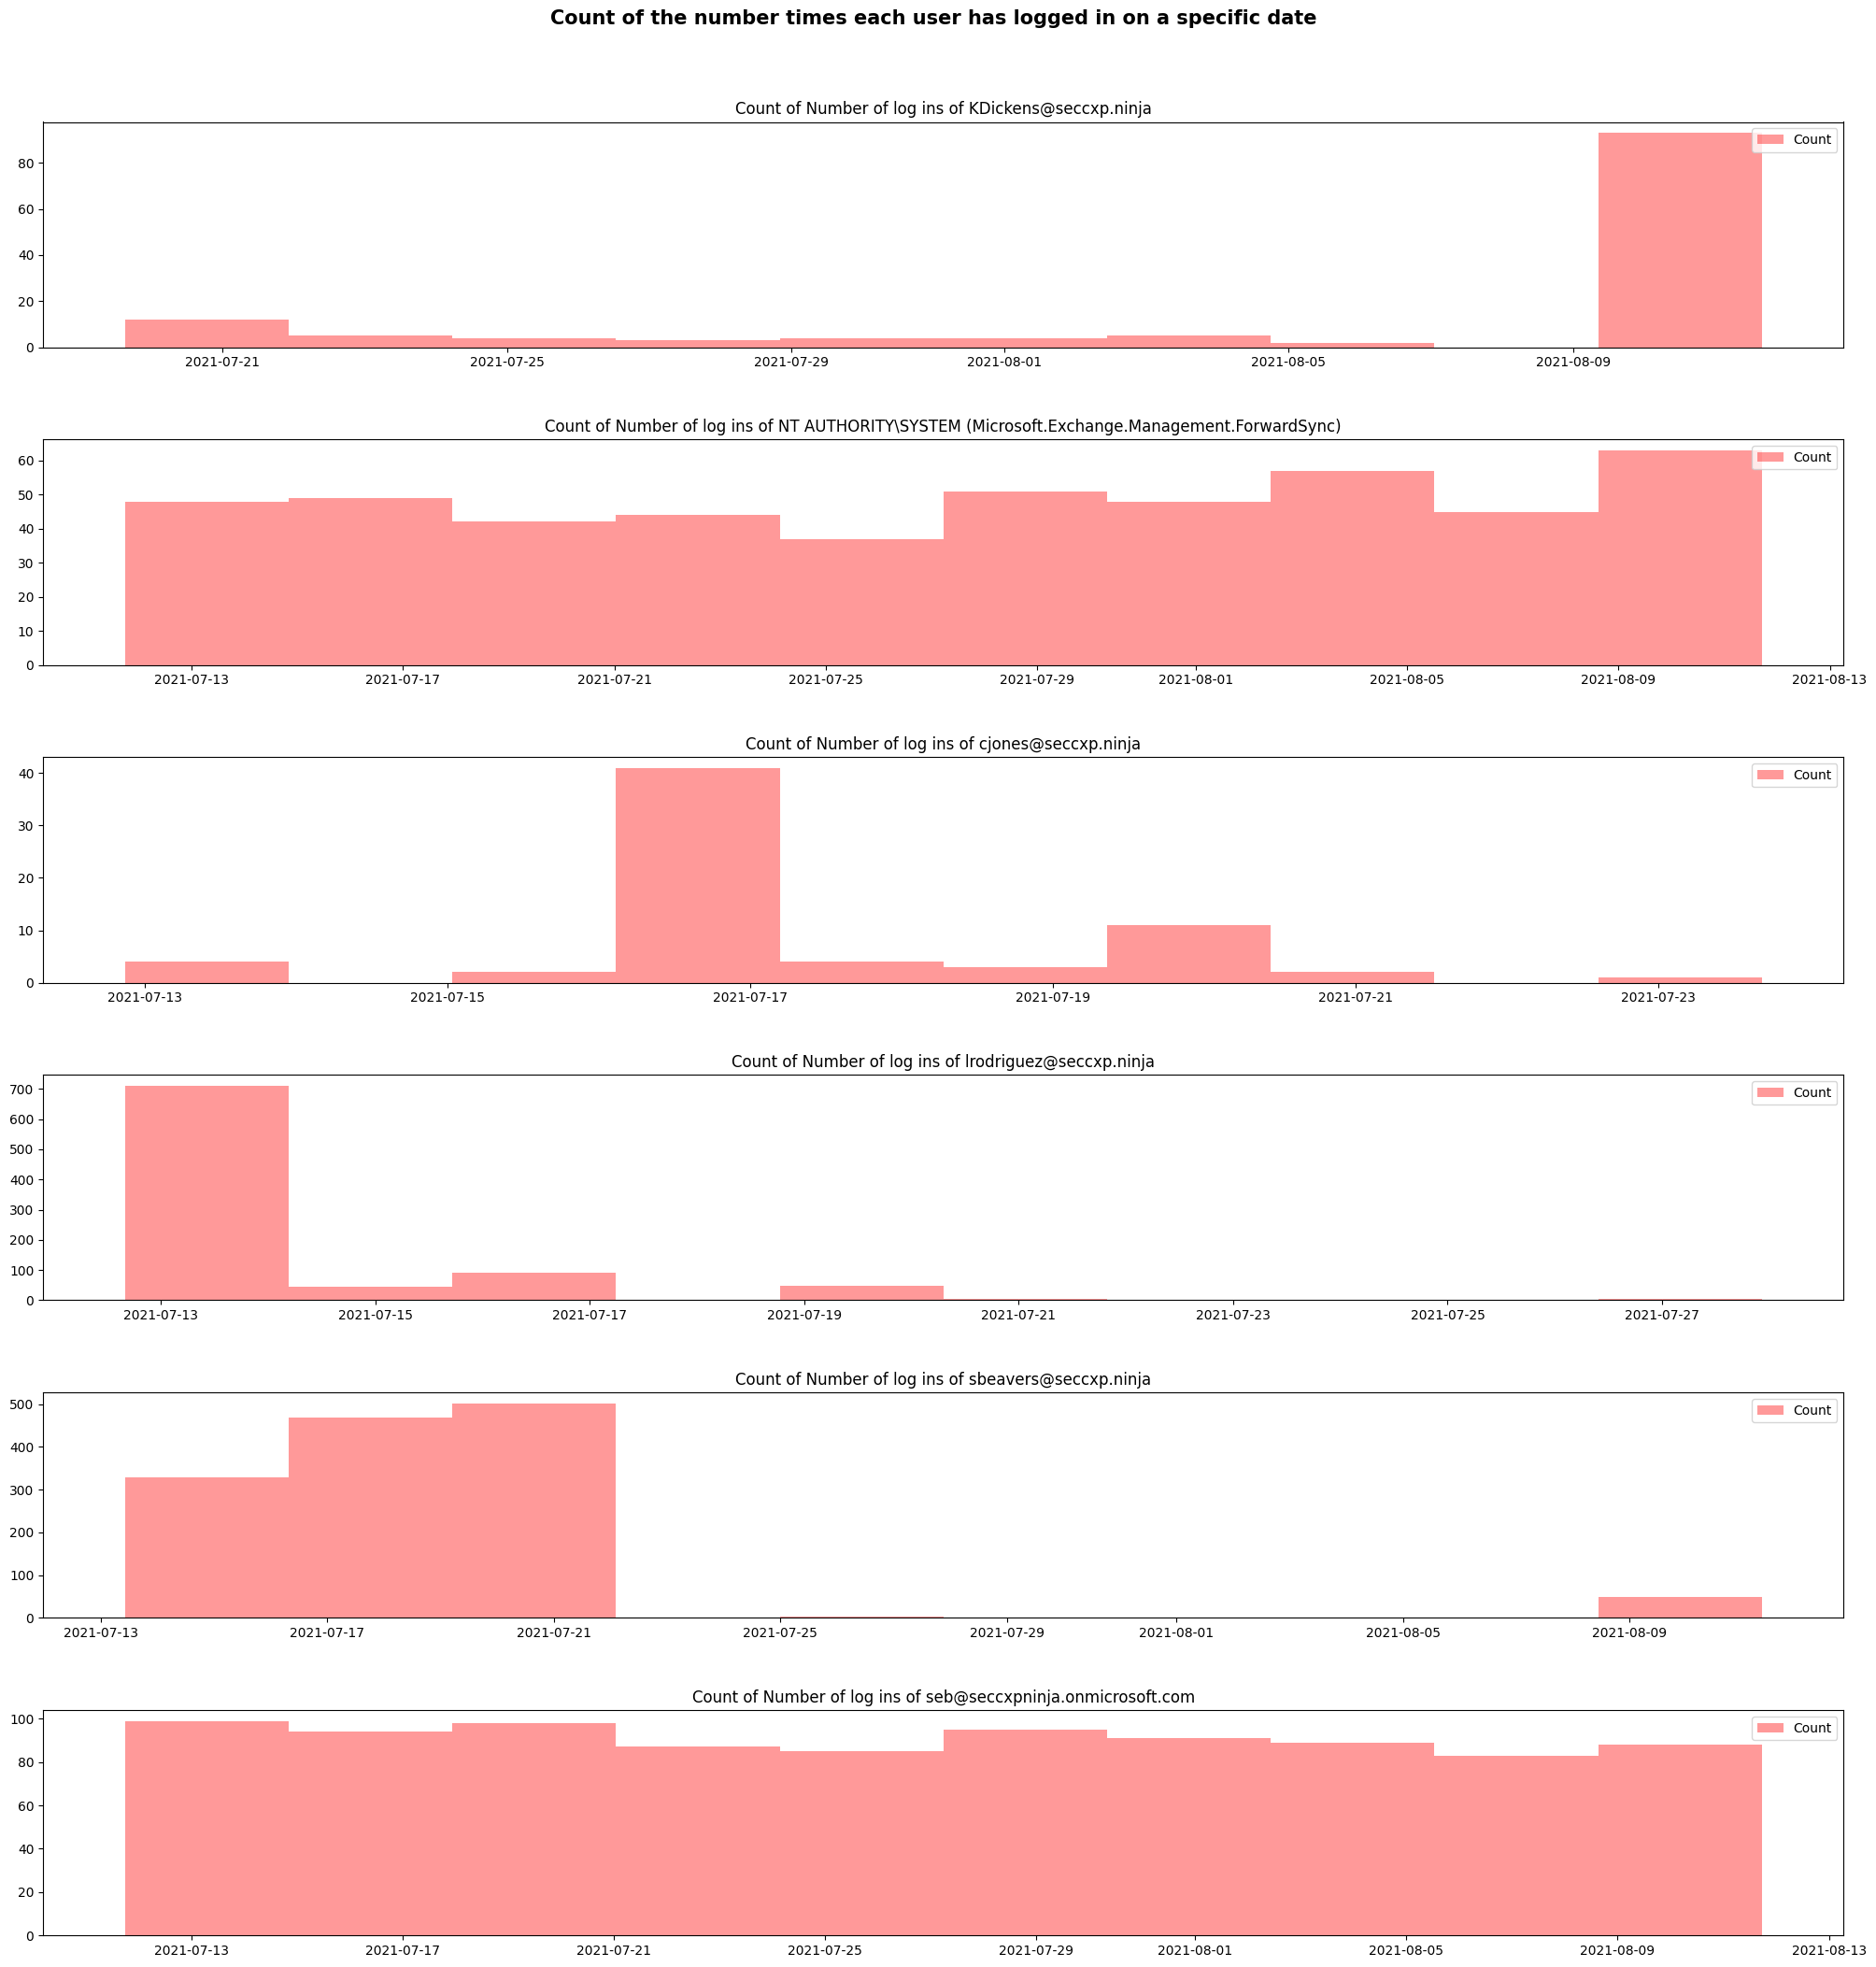

In [255]:
fig, ax = plt.subplots(len(anomaly_data_model[user_entities[0]]))
fig.set_figwidth(20)
fig.set_figheight(20)
fig.tight_layout(h_pad=5)
count = 0
fig.suptitle("Count of the number times each user has logged in on a specific date", fontweight ="bold", fontsize=15, y= 1.05)


#histtype = 'step' linewidth=4
for i in anomaly_data_model["Login Times"]:
    temp_lst = list(i)
    x = list(i)
    ax[count].hist(x, alpha = 0.4, facecolor="red",histtype = 'stepfilled')
    ax[count].title.set_text("Count of Number of log ins of {}".format(anomaly_data_model.loc[count,user_entities[0]])) 
    ax[count].legend(["Count"])
    count+=1

plt.show()